# Standard GAN on MNIST

Based on the original Generative Adversarial Network (GAN), as introduced by Goodfellow et al. in 2014 [1]

## Learning goals

- Learn about the GAN deep neural network
- Design a clean implementation using Keras high level models (Sequential)
- Use the new Tensorflow Dataset input data pipeline

In [1]:
COLAB = True
if COLAB:
  from google.colab import drive
  drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
!pip install tensorview

In [3]:
import sys
import tensorflow as tf
import plotly.graph_objects as go
from ipywidgets import widgets
import numpy as np
from tensorflow.keras import models, layers, losses, optimizers, metrics
import tensorflow_datasets as tf_ds
import tensorview as tv
import matplotlib.pyplot as plt
from pathlib import Path

/usr/local/lib/python3.6/dist-packages/requests/__init__.py:91: RequestsDependencyWarning: urllib3 (1.26.2) or chardet (3.0.4) doesn't match a supported version!
  RequestsDependencyWarning)


In [4]:
if COLAB:
  model_path = Path('/content/drive/My Drive/Colab Notebooks/DsStepByStep')
else:
  model_path = Path('model')

In [5]:
batch_size = 100
latent_dim = 100
image_width, image_height, image_channels = 32, 32, 1
mnist_dim = image_width * image_height * image_channels

In [6]:
disc_learning_rate = 0.0002
gen_learning_rate  = 0.0002

relu_alpha = 0.01

# Data

MNIST dataset is optimized to be stored efficiently: images are closely cropped at 28x28 pixels and stored as 1 byte per pixel (uint8 format). However, to get proper performance we need to modify the input data to insert some padding around and convert the pixel format to float on 32 bits.

In [7]:
def normalize_img(image, label):
  """Normalizes images: `uint8` -> `float32` and pad to 32 x 32"""
  image_float = tf.cast(image, tf.float32) / 128. - 1.
  image_padded = tf.pad(image_float, [[0, 0], [2, 2], [2, 2], [0, 0]])
  return image_padded, label

(ds_train, ds_test) = tf_ds.load('mnist', split=['train', 'test'], batch_size=batch_size, as_supervised=True)
ds_train = ds_train.map(normalize_img)
ds_train = ds_train.cache()

ds_test = ds_test.map(normalize_img)
ds_test = ds_test.cache()

ds_train, ds_test

local data directory. If you'd instead prefer to read directly from our public
GCS bucket (recommended if you're running on GCP), you can instead pass
`try_gcs=True` to `tfds.load` or set `data_dir=gs://tfds-data/datasets`.





Dataset mnist downloaded and prepared to /root/tensorflow_datasets/mnist/3.0.1. Subsequent calls will reuse this data.


(<CacheDataset shapes: ((None, 32, 32, 1), (None,)), types: (tf.float32, tf.int64)>,
 <CacheDataset shapes: ((None, 32, 32, 1), (None,)), types: (tf.float32, tf.int64)>)

# Models

GAN model is built out of a generator and a discriminator:
- The generator gets as input some random noise on space of 100 dimensions, and issues an image (32x32 pixel raster)
- The discriminator is trained to distinguish generated images by the generator (i.e. _fakes_), and reference images from the MNIST

The generator and discriminator architecture are more or less symmetrical. The generator is increasing the output space dimension step by step using wider and wider layers. The discriminator is similar to other classification networks reducing the input space dimensions down to the binary classification layer.

The "game" is to jointly train the generator and discriminator in order to have the best generator but still being able to detect generated images.

In [8]:
generator = models.Sequential([
    layers.Dense(256, input_dim=latent_dim),
    layers.LeakyReLU(relu_alpha),
    layers.Dropout(0.3),
    layers.Dense(512),
    layers.LeakyReLU(relu_alpha),
    layers.Dense(1024),
    layers.LeakyReLU(relu_alpha),
    layers.Dense(mnist_dim, activation='tanh'),
    layers.Reshape([32, 32, 1]),
], name='generator')

generator.compile()
generator.summary()

Model: "generator"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 256)               25856     
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 256)               0         
_________________________________________________________________
dropout (Dropout)            (None, 256)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 512)               131584    
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 512)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 1024)              525312    
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 1024)              0 

In [9]:
discriminator = models.Sequential([
    layers.Input(shape=[32, 32, 1]),
    layers.Flatten(),
    layers.Dropout(0.3),
    layers.Dense(1024),
    layers.LeakyReLU(relu_alpha),
    layers.Dense(512),
    layers.LeakyReLU(),
    layers.Dense(256),
    layers.LeakyReLU(relu_alpha),
    layers.Dense(1) # activation='sigmoid'
], name='discriminator')

discriminator.compile()
discriminator.summary()

Model: "discriminator"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 1024)              0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 1024)              0         
_________________________________________________________________
dense_4 (Dense)              (None, 1024)              1049600   
_________________________________________________________________
leaky_re_lu_3 (LeakyReLU)    (None, 1024)              0         
_________________________________________________________________
dense_5 (Dense)              (None, 512)               524800    
_________________________________________________________________
leaky_re_lu_4 (LeakyReLU)    (None, 512)               0         
_________________________________________________________________
dense_6 (Dense)              (None, 256)             

# Training

Training is alternatively on the distriminator and generator.

The discriminator is trained on a batch made of half genuine images and half trained images.

The generator is trained with its output fed into the discriminator (whose wheights are frozen in this phase).

GAN reputation as difficult to be trained is well deserved and originates in the joint optimization which is similar to a minimax problem (min discrination error, max fidelity of the fakes). As seen below, the noise on the losses and accuracies is high. The main facilitators helping this training are:
- Use of leaky ReLU activations to avoid gradient vanishing
- Small learning rate to decrease the noise and instability


In [10]:
epochs = 60
batch_per_epoch = 60000/batch_size
loss_object = tf.keras.losses.BinaryCrossentropy(from_logits=True)

In [11]:
def generator_loss(disc_generated_output):
    return loss_object(tf.ones_like(disc_generated_output), disc_generated_output)

In [12]:
def discriminator_loss(disc_real_output, disc_generated_output):

    real_loss = loss_object(tf.ones_like(disc_real_output), disc_real_output)
    generated_loss = loss_object(tf.zeros_like(disc_generated_output), disc_generated_output)

    return real_loss + generated_loss

In [13]:
@tf.function
def train_step(generator, discriminator, 
               generator_optimizer, discriminator_optimizer, 
               generator_latent, batch, 
               epoch):
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        
        gen_latent = generator_latent()
        
        gen_output = generator(gen_latent, training=True)

        disc_real_output = discriminator(batch, training=True)
        disc_generated_output = discriminator(gen_output, training=True)

        gen_loss = generator_loss(disc_generated_output)
        disc_loss = discriminator_loss(disc_real_output, disc_generated_output)

        generator_gradients = gen_tape.gradient(gen_loss, generator.trainable_variables)
        discriminator_gradients = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(generator_gradients, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(discriminator_gradients, discriminator.trainable_variables))

    return gen_loss, disc_loss

In [14]:
generator_optimizer = tf.keras.optimizers.Adam(gen_learning_rate, beta_1=0.05)
discriminator_optimizer = tf.keras.optimizers.Adam(disc_learning_rate, beta_1=0.05)

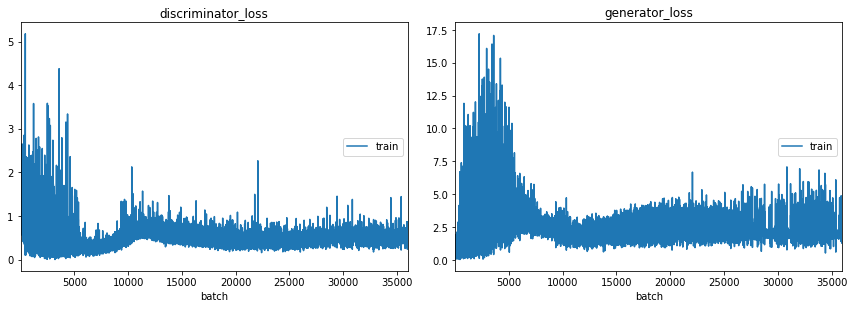

In [15]:
tv_plot = tv.train.PlotMetrics(wait_num=200, columns=2, iter_num=epochs * batch_per_epoch)

def generator_latent():
    return tf.random.normal((batch_size, latent_dim), 0, 1)

for epoch in range(epochs):

    for train_batch in iter(ds_train):
        
        g_loss, d_loss = train_step(generator, discriminator, 
                                    generator_optimizer, discriminator_optimizer, 
                                    generator_latent, train_batch[0], 
                                    epoch)
        # Plot
        tv_plot.update({ 'discriminator_loss': d_loss,# 'discriminator_acc': d_acc,
                        'generator_loss': g_loss, # 'generator_acc': g_acc
                       })
        tv_plot.draw()

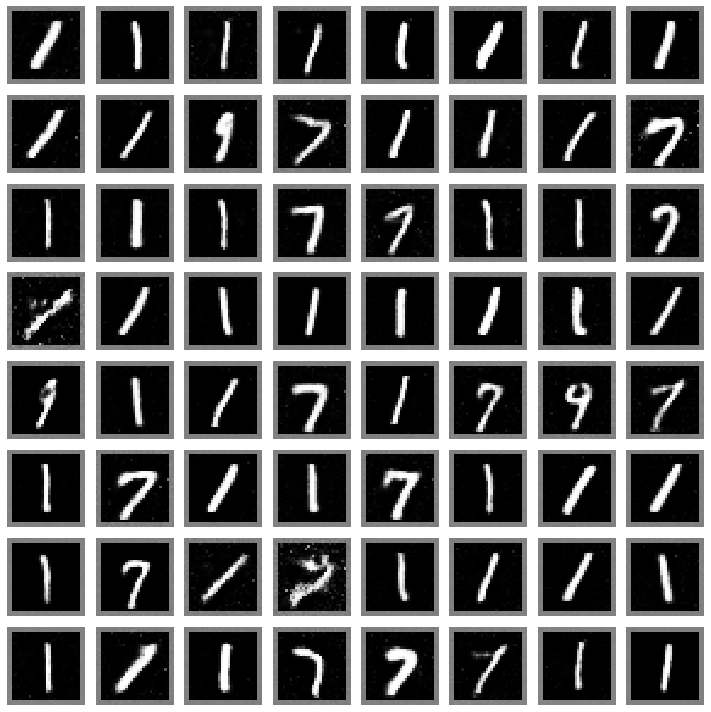

In [16]:
gen_latent = generator_latent()
gen_imgs = generator(gen_latent, training=True).numpy()

fig, axes = plt.subplots(8, 8, sharex=True, sharey=True, figsize=(10, 10))
for img, ax in zip(gen_imgs, axes.ravel()):
    ax.imshow(img.reshape(image_width, image_height), interpolation='nearest', cmap='gray')
    ax.axis('off')
fig.tight_layout()

In [17]:
discriminator.save(model_path / 'mnist_gan_discriminator.h5')
generator.save(model_path / 'mnist_gan_generator.h5')

# Conclusion

The generator is not fooling that much the discriminator since the discriminator accuracy is well above 50% and its loss is stable at a low level. However, the generated digits are quite well looking to an human eye.

## Where to go from here

- More advanced GAN based on convolutional layers ([HTML](MNIST_DCGAN.html) / [Jupyter](MNIST_DCGAN.ipynb))
- Revisit the fundamentals about deep neural networks in the CNN versus Dense classification ([HTML](../cnn/CnnVsDense-Part1.html) / [Jupyter](../cnn/CnnVsDense-Part1.jupyter) )

## References

1. ["Generative adversarial nets"](http://papers.nips.cc/paper/5423-generative-adversarial-nets.pdf), I. Goodfellow, J. Pouget-Abadie, M. Mirza, B. Xu, D. Warde-Farley, S. Ozair, A. Courville, Y. Bengio, NIPS 2014